In [1]:
#library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

In [2]:
df = pd.read_csv('bank-additional-full.csv')
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
from sklearn.model_selection import train_test_split

# Remove duplicates
df.drop_duplicates(inplace=True)

# Convert target labels to numeric
df['y'] = df['y'].map({'yes': 1, 'no': 0}).astype(int)

# Handling missing or unknown values
df.replace("unknown", np.nan, inplace=True)
df.dropna(inplace=True)  # Drop rows with missing values (alternative: impute values)

# One-hot encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Train-test split
X = df.drop(columns=['y'])
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

In [4]:
X_train.shape

(24382, 47)

In [5]:
X_test.shape

(6096, 47)

In [6]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000,30478.000000
mean,39.029694,259.513124,2.521721,956.318295,0.194337,-0.071425,93.523376,-40.602579,3.459976,5160.813967,0.126583
std,10.332746,261.746393,2.720495,201.404843,0.522862,1.610306,0.585366,4.788790,1.777215,75.158267,0.332511
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,31.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.313000,5099.100000,0.000000
50%,37.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.444000,-41.800000,4.856000,5191.000000,0.000000
75%,45.000000,321.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,95.000000,4918.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [7]:
#Creating Dummies for categorical variables
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [8]:
X_train.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
16268,32,124,2,999,0,1.4,93.918,-42.7,4.961,5228.1,...,False,False,False,False,False,False,True,False,True,False
10202,38,361,2,999,0,1.4,94.465,-41.8,4.958,5228.1,...,False,False,False,False,False,True,False,False,True,False
27953,32,364,3,999,0,-1.8,92.843,-50.0,1.520,5099.1,...,False,False,False,False,True,False,False,False,True,False
13662,30,58,1,999,0,1.4,93.918,-42.7,4.963,5228.1,...,False,False,False,False,False,True,False,False,True,False
24617,39,148,2,999,1,-0.1,93.200,-42.0,4.191,5195.8,...,False,True,False,False,True,False,False,False,False,False


Gradient Boosting

In [10]:
n_estimators = [25,50,75,100,200]
max_depth = [1,3,5]

param_grid = {'n_estimators': list(n_estimators),
              'max_depth': list(max_depth)
              }
print("Parameter grid:\n{}".format(param_grid))

#Setup Grid Search
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=1,learning_rate = 0.05)
,verbose = 2, param_grid = param_grid, cv=3, return_train_score=True)
grid_search.fit(X_train, y_train)

Parameter grid:
{'n_estimators': [25, 50, 75, 100, 200], 'max_depth': [1, 3, 5]}
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END .......................max_depth=1, n_estimators=25; total time=   0.1s
[CV] END .......................max_depth=1, n_estimators=25; total time=   0.1s
[CV] END .......................max_depth=1, n_estimators=25; total time=   0.1s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.3s
[CV] END .......................max_depth=1, n_estimators=75; total time=   0.5s
[CV] END .......................max_depth=1, n_estimators=75; total time=   0.5s
[CV] END .......................max_depth=1, n_estimators=75; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.7s
[CV] END ......................max_depth=1, n_es

GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                  random_state=1),
             param_grid={'max_depth': [1, 3, 5],
                         'n_estimators': [25, 50, 75, 100, 200]},
             return_train_score=True, verbose=2)

In [11]:
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.score)

{'max_depth': 5, 'n_estimators': 100}
0.9091132261568079
<bound method BaseSearchCV.score of GridSearchCV(cv=3,
             estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                  random_state=1),
             param_grid={'max_depth': [1, 3, 5],
                         'n_estimators': [25, 50, 75, 100, 200]},
             return_train_score=True, verbose=2)>


In [12]:
gs_results = pd.DataFrame(grid_search.cv_results_).sort_values(by = "mean_test_score", ascending = False)

In [13]:
gs_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
13,3.333298,0.139235,0.016326,0.000622,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.910433,0.910176,0.906731,0.909113,0.001688,1,0.929802,0.927222,0.925992,0.927672,0.001588
12,2.464024,0.019208,0.015092,0.001561,5,75,"{'max_depth': 5, 'n_estimators': 75}",0.907972,0.912022,0.906731,0.908908,0.002259,2,0.926357,0.923839,0.922670,0.924288,0.001538
11,1.724176,0.062442,0.012292,0.000651,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.906373,0.911160,0.905254,0.907596,0.002562,3,0.922911,0.920947,0.920640,0.921499,0.001006
9,4.119611,0.047110,0.021900,0.002738,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.908588,0.908453,0.905377,0.907473,0.001483,4,0.917866,0.916887,0.915841,0.916865,0.000827
14,6.537916,0.087893,0.026007,0.000332,5,200,"{'max_depth': 5, 'n_estimators': 200}",0.908465,0.907961,0.904393,0.906939,0.001812,5,0.940815,0.939034,0.939649,0.939833,0.000738


In [24]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

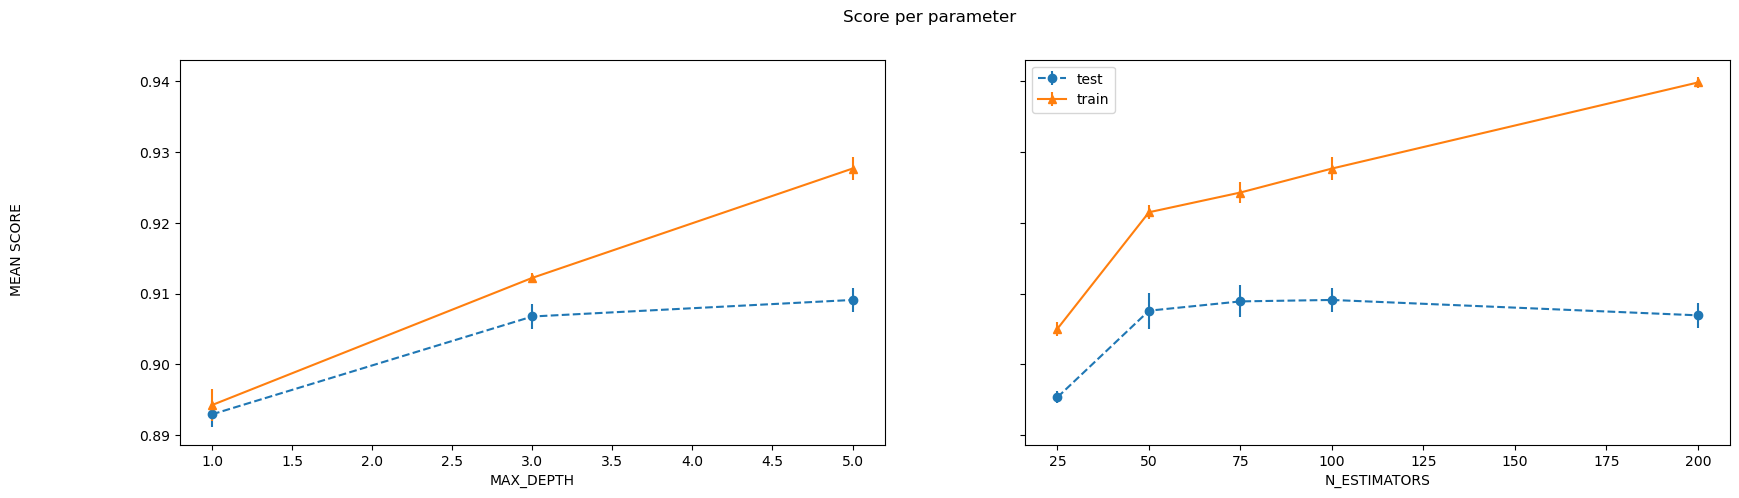

In [25]:
plot_search_results(grid_search)

In [26]:
grid_search.best_estimator_

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, random_state=1)

In [29]:
#Train final model
classifiergb = grid_search.best_estimator_
classifiergb.fit(X_train, y_train)

# Applying k-Fold Cross Validation
accuracies = cross_val_score(estimator = grid_search.best_estimator_, X = X_train, y = y_train, cv = 3,n_jobs=-1)
mean_boosting=accuracies.mean()
std_boosting=accuracies.std()

In [30]:
print(mean_boosting)
print(std_boosting)

0.9091132261568079
0.0016880018772292829


<BarContainer object of 10 artists>

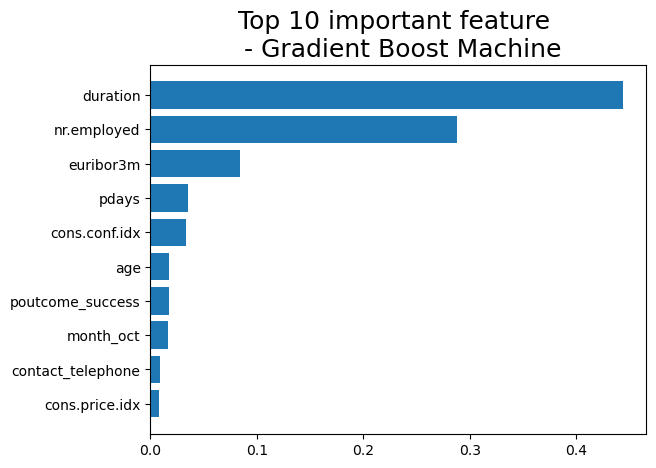

In [31]:
d = {'name':classifiergb.feature_names_in_,'importance_score':classifiergb.feature_importances_}
importance_feature = pd.DataFrame(d).sort_values(by = "importance_score", ascending = False)
importance_feature_top = importance_feature[0:10].sort_values(by = "importance_score", ascending = True)
plt.title("Top 10 important feature \n - Gradient Boost Machine", fontsize=18)
plt.barh(importance_feature_top.name,importance_feature_top.importance_score)

Test Output:
Confusion Matrix:
[[20591   705]
 [ 1154  1932]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     21296
           1       0.73      0.63      0.68      3086

    accuracy                           0.92     24382
   macro avg       0.84      0.80      0.82     24382
weighted avg       0.92      0.92      0.92     24382

Accuracy:  0.9237552292674924
Precision Score:  0.732650739476678
Recall Score:  0.626053143227479
(array([0.94693033, 0.73265074]), array([0.96689519, 0.62605314]), array([0.95680862, 0.67517037]), array([21296,  3086], dtype=int64))
AUC for training data is 0.9572992357088288


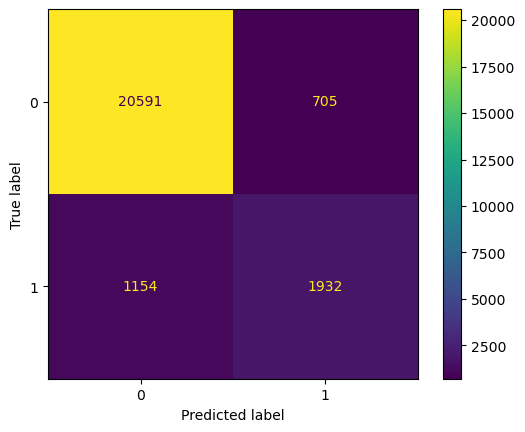

In [ ]:
# Predicting the Training set results
y_predgb = classifiergb.predict(X_train)
y_predgb_score = classifiergb.predict_proba(X_train)

#Confusion Matrix
print('Test Output:')
print('Confusion Matrix:')
cm = confusion_matrix(y_train, y_predgb)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifiergb.classes_)
disp.plot()
print('Classification Report:')
print(classification_report(y_train, y_predgb))
print('Accuracy: ',accuracy_score(y_train,y_predgb))

print('Precision Score: ', precision_score(y_train, y_predgb))
print('Recall Score: ', recall_score(y_train, y_predgb)) 
print(precision_recall_fscore_support(y_train, y_predgb))

# Gradient Boosting Classifier
grd_fpr, grd_tpr, thresold = roc_curve(y_train, y_predgb_score[:,1])
print("AUC for training data is",auc(grd_fpr, grd_tpr))

Test Output:
Confusion Matrix:
[[5095  229]
 [ 344  428]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5324
           1       0.65      0.55      0.60       772

    accuracy                           0.91      6096
   macro avg       0.79      0.76      0.77      6096
weighted avg       0.90      0.91      0.90      6096

Accuracy:  0.906003937007874
Precision Score:  0.6514459665144596
Recall Score:  0.5544041450777202
(array([0.93675308, 0.65144597]), array([0.95698723, 0.55440415]), array([0.94676206, 0.59902029]), array([5324,  772], dtype=int64))


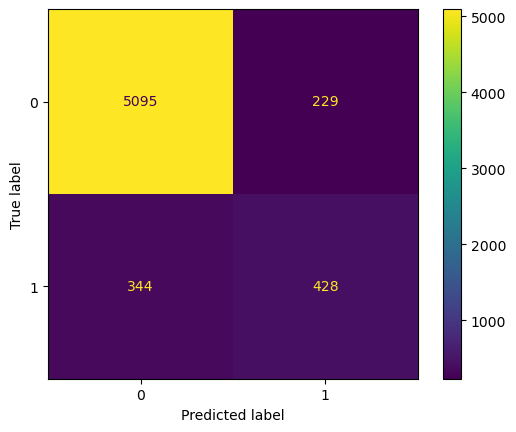

In [ ]:
# Predicting the Test set results
y_predgb = classifiergb.predict(X_test)
y_predgb_score = classifiergb.predict_proba(X_test)

#Confusion Matrix
print('Test Output:')
print('Confusion Matrix:')
cm = confusion_matrix(y_test, y_predgb)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifiergb.classes_)
disp.plot()
print('Classification Report:')
print(classification_report(y_test, y_predgb))
print('Accuracy: ',accuracy_score(y_test,y_predgb))

print('Precision Score: ', precision_score(y_test, y_predgb))
print('Recall Score: ', recall_score(y_test, y_predgb)) 
print(precision_recall_fscore_support(y_test, y_predgb))

In [36]:
# Gradient Boosting Classifier
grd_fpr, grd_tpr, thresold = roc_curve(y_test, y_predgb_score[:,1])
print("AUC is",auc(grd_fpr, grd_tpr))

AUC is 0.9451669145097185


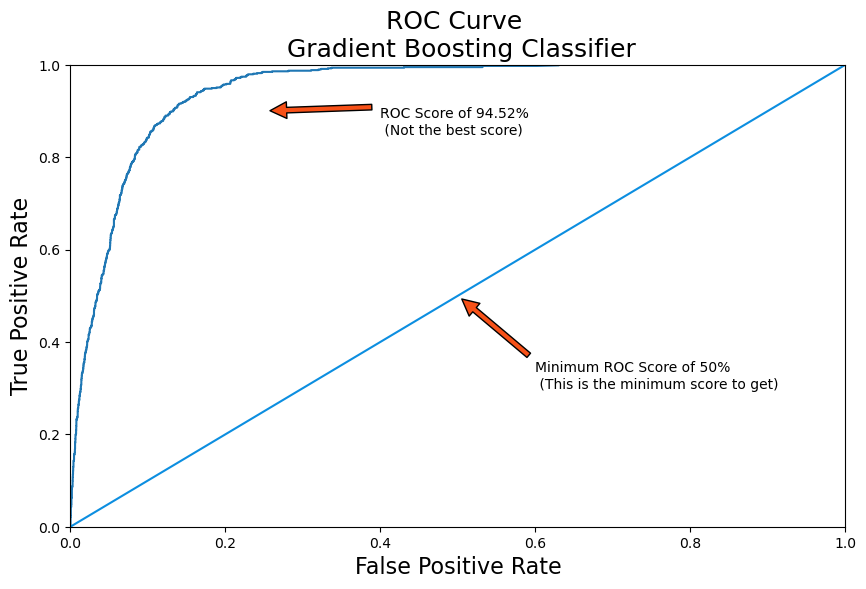

In [37]:
def graph_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.figure(figsize=(10,6))
    plt.title('ROC Curve \n Gradient Boosting Classifier', fontsize=18)
    plt.plot(false_positive_rate, true_positive_rate, label=label)
    plt.plot([0, 1], [0, 1], '#0C8EE0')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('ROC Score of {:.2%}\n (Not the best score)'.format(auc(grd_fpr, grd_tpr)), xy=(0.25, 0.9), xytext=(0.4, 0.85),
            arrowprops=dict(facecolor='#F75118', shrink=0.05),
            )
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#F75118', shrink=0.05),
                )
graph_roc_curve(grd_fpr, grd_tpr)
plt.show()